In [1]:
#Shows each individual plot along with which model best fits it
import pickle, math
import pandas as pd
import sqlite3
import random
import os
#exec(open("./Imports.py").read())
execfile('Imports.py')
# _add_modules_path()
import Modules.Funcs as funcs
from Modules.Classes import Simulation
from Modules.Classes import CopyTweak
from Modules.Classes import CopyTweakRep
from Modules.Classes import Packer
from Modules.Classes import PackerRep
from Modules.Classes import ConjugateJK13
from Modules.Classes import RepresentJK13
from Modules.Classes import NegatedSpace
from Modules.Classes import NConjugateJK13
from Modules.Classes import NRepresentJK13
from Modules.Classes import NPacker
from Modules.Classes import NCopyTweak

from scipy.stats import stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Specify default dataname
dbname = 'experiment-xcrABC.db'#raw data
dataname_def = 'xcrABC'#bestparms also comes from here

#plotting options
STAT_LIMS =  (-1.0, 1.0)
#Fit to only last trial?
fitlast = False
#Make plots?
doplots = True
saveplots = False
if fitlast:
    showlast = True
else:
    showlast = False #True = Show last even if fitting to all?
#Bootstrap parameters
nbootstraps = 1000
if fitlast and showlast:
    savedir = 'private/individual_modelcomp_{}/fitlast'.format(dataname_def)
elif showlast:
    savedir = 'private/individual_modelcomp_{}/showonlylast/'.format(dataname_def)
elif fitlast:
    savedir = 'private/individual_modelcomp_{}/fitlast'.format(dataname_def)
else:
    savedir = 'private/individual_modelcomp_{}/showall'.format(dataname_def)
# savefilename='modelvsppt{}_t.pdf'.format(corrtype)
# modeleaseDB = "pickles/modelease_corr{}.p".format(corrtype)

#Some plotting options
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 15}

#Specify simulation values
N_SAMPLES = 10000
WT_THETA = 1.5
MIN_LL = 1e-10


participant_def = 'all'
unique_trials_def = 'all'
dataname = dataname_def
execfile('validate_data.py')

bestparmdb = "pickles/chtc_gs_best_params_{}".format(src)


plt.rc('font', **font)

# get data from pickle
with open(pickledir+src, "rb" ) as f:
    trials = pickle.load( f )

# get best params pickle
#bestparmdb = "pickles/chtc_gs_best_params_all_data_e1_e2.p"
#bestparmdb = "pickles/chtc_gs_best_params_corrs.p"
with open(bestparmdb, "rb" ) as f:
    best_params_t = pickle.load( f )

#Rebuild it into a smaller dict
best_params = dict()
for modelname in best_params_t.keys():    
    best_params[modelname] = dict()
    for i,parmname in enumerate(best_params_t[modelname]['parmnames']):
        parmval = best_params_t[modelname]['bestparmsll']
        best_params[modelname][parmname] = parmval[i]
modelList = [Packer,RepresentJK13]#,NPacker,NRepresentJK13]
#modelList = [CopyTweak,CopyTweakRep,Packer, RepresentJK13,]                            

#Specify plot order
modelPlotOrder = np.array([[Packer,RepresentJK13],[NPacker,NRepresentJK13]])
#modelPlotOrder = np.array([[CopyTweak,CopyTweakRep],[Packer,RepresentJK13]])

#Prepare matched database    
matchdb='../cat-assign/data_utilities/cmp_midbot.db'
        
unique_trials = 'all'
trials.task = task




In [2]:
con = sqlite3.connect(dbname)
participants = pd.read_sql_query("SELECT participant, condition from participants", con)
generation = pd.read_sql_query("SELECT * from generation", con)
alphas = pd.read_sql_query("SELECT * from alphas", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).values
con.close()


Ppt: 3


/Users/sourguyxian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Ppt: 11
Ppt: 18
Ppt: 37
Ppt: 39


KeyboardInterrupt: 

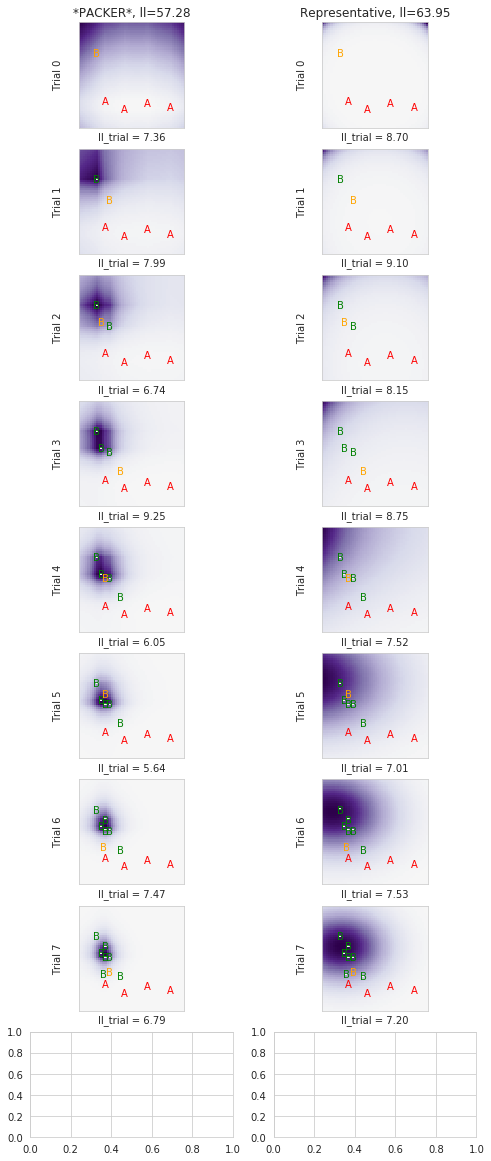

In [3]:
#Go through each participant and get their fits for each model
ll = []
ll_trials = []
tally = np.zeros(len(modelList))
wins = []
pptcond_tally = dict()
for ppt in trials.participants:#[318]:
    ppt = int(ppt)
    print('Ppt: ' + str(ppt))
    llrow = []
    if fitlast:
        extract_trials = 3
    else:
        extract_trials = 'all'
    conditionStr = participants.condition[participants.participant==ppt].values
    if conditionStr not in pptcond_tally.keys():
        pptcond_tally[conditionStr[0]] = 0
    pptcond_tally[conditionStr[0]] += 1
    pptconstr = conditionStr[0][0:2]
    if "Corner" in conditionStr[0]:
        pptconstr += conditionStr[0][-1] #Add info on whether square or circle
    
    trialppt = Simulation.extractPptData(trials, ppt=ppt, unique_trials=extract_trials)
    #Hacky code, but necessary for now
    #For categories to be ints
    for ti,trial in enumerate(trialppt.Set):
        trialppt.Set[ti]['categories'] = [np.array(tt,dtype=int) for tt in trial['categories']]
        trialppt.Set[ti]['response'] = [np.array(tt,dtype=int) for tt in trial['response']]


    #Get list of lls and winning model
    for model in modelList:
        params = best_params[model.model]
        ppt_trial_ll = trialppt.loglike(params=params,model=model,parmxform=False)
        llrow += [ppt_trial_ll]
    bestmodel = llrow.index(np.min(llrow))
    bestmodelstr = modelList[bestmodel].modelshort
    ll += [[ppt]+llrow]
    tally[bestmodel] += 1
    wins += [bestmodel]
    #Prepare stuff fot plotting
    if doplots:
        
        #Sort trial obj by trial number - really only applicable if onlylast is false                                                                                                                   
        trialOrder = []
        maxbeta = 0
        for t,trialobj in enumerate(trialppt.Set):
            #nbeta = len(trialobj['categories'][1])
            nbeta = 0
            for ii,new_exm in enumerate(trialobj['categories']):
                if not ii == 0: #Ignore alpha cat
                    nbeta += len(new_exm)
            trialppt.Set[t]['trial'] = nbeta
            trialOrder += [nbeta]
            maxbeta = max(nbeta,maxbeta)
        trialOrder = np.argsort(trialOrder)
        wrap_ax = trialppt.Set[0]['wrap_ax'][0]
        if wrap_ax==1:
            wrapstr = '<-Wrapped->'
        else:
            wrapstr = ''
        #Add dummy last trial to plot gradients for hypothetical fifth beta
        respSet = trialppt.Set[trialOrder[maxbeta]]['response']
        if hasattr(respSet[0],'__len__'):
            for resps in respSet:
                if len(resps)>0:
                    resp = resps
        else:
            resp = respSet
        newcatB = np.append(trialppt.Set[trialOrder[maxbeta]]['categories'][1],resp)
        newcatAll = [trialppt.Set[trialOrder[maxbeta]]['categories'][0],newcatB]
        trialppt.add(response=0,categories=newcatAll, participant = ppt,wrap_ax = wrap_ax)
        trialOrder = np.append(trialOrder,maxbeta+1)
        
        if showlast:
            ntrials = 1
            plottrials = [len(trialppt.Set)-1] #plot only last trial
        else:
            ntrials = len(trialppt.Set)
            plottrials = range(ntrials)
        f,ax = plt.subplots(ntrials,len(modelList),figsize = (8, 2*ntrials+2.5))
        for trial in plottrials:
            categories = [trialppt.stimuli[i,:] for i in trialppt.Set[trialOrder[trial]]['categories'] if len(i)>0]
            A = categories[0]
            respSet = trialppt.Set[trialOrder[trial]]['response']
            if hasattr(respSet[0],'__len__'):
                for ri,resps in enumerate(respSet):
                    if len(resps)>0:
                        respCat = ri
                        resp = trialppt.stimuli[resps,:]
            else:
                resp = trialppt.stimuli[respSet,:]
            if len(categories)>1:
                if respCat==1:
                    #include the response                                                                                                                  
                    B = np.append(categories[1],resp,axis=0)
                    if showlast:
                        #Include response in generatin of ps                
                        categories[1] = B
                elif respCat==2:
                    if len(categories)<3:
                        C = resp
                    else:
                        C = np.append(categories[2],resp,axis=0)
                    if showlast:
                        #Include response in generatin of ps                
                        categories[2] = C
            else:
                #categories += [resp]
                B = resp
                C = []
            ps = []
            ll_trial = []
            for m,model in enumerate(modelList):
                if m==bestmodel:
                    winstr = '*'
                else:
                    winstr = ''
                if ntrials>1:
                    ax[0,m].set_title('{}{}{}, ll={:.2f}'.format(winstr,model.modelshort,winstr,llrow[m]))
                else:                    
                    ax[m].set_title('{}{}{}, ll={:.2f}'.format(winstr,model.modelshort,winstr,llrow[m]))
                params = best_params[model.model]
                #Plot heatmap for each model
                ps += [model(categories,params,trialppt.stimrange,wrap_ax=wrap_ax).get_generation_ps(trialppt.stimuli,1,'generate')]
                #Get lls for each trial step
                ll_trial += [trialppt.loglike(params=params,model=model,parmxform=False,whole_array=True)]

            #Plot the individual plots
            plotct = 0
            plotVals = []
            psMax = 0
            psMin = 1
            #Get range                                                                                                                                     
            for ps_el in ps:
                psMax = max(psMax,ps_el.max())
                psMin = min(psMin,ps_el.min())

            #Normalise all values                                                                                                                          
            psRange = psMax-psMin
            for i,ps_el in enumerate(ps): #each ps element correspond to a model
                plotct += 1
                gps = funcs.gradientroll(ps_el,'roll')[:,:,0]
                ps_ElRange = gps.max()-gps.min();
                plotVals += [(gps-gps.min())/ps_ElRange]                                                                             
                betacol = ['green' for bi in range(len(B))]
#                 if task is 'generate':
#                     betacol[len(B)-1] = 'orange'
                if ntrials>1:
                    betacol[len(B)-1] = 'orange'
                    if trial == ntrials-1:
                        betacol[len(B)-1] = [0,0,0,0]
                    im = funcs.plotgradient(ax[trial,i], plotVals[i], A, B, clim = STAT_LIMS, cmap = 'PuOr',beta_col=betacol,gammas=C)
                    ax[trial,i].set_ylabel('Trial {}\n{}'.format(trial,wrapstr))
                    if trial<ntrials-1:
                        ax[trial,i].set_xlabel('ll_trial = {:.2f}'.format(ll_trial[i][trial]),fontsize=10)
                    #else:
                        
                else:
                    im = funcs.plotgradient(ax[i], plotVals[i], A, B, clim = STAT_LIMS, cmap = 'PuOr',beta_col=betacol,gammas=C)
#                     ax[i].set_ylabel('Trial {}'.format(trial))
        #Save fig
        if saveplots:
            savedirext = '{}/{}'.format(savedir,bestmodelstr)
            if os.path.isdir(savedirext):
                plt.savefig('{}/{}_{}_{}'.format(savedirext,pptconstr,int(ppt),bestmodelstr[0]))
            else:
                os.mkdir(savedirext)
                plt.savefig('{}/{}_{}_{}'.format(savedirext,pptconstr,int(ppt),bestmodelstr[0]))
        plt.close()
        ll_trials += [np.array(ll_trial).T]


    


In [ ]:
for ii,trialt in enumerate(trials.Set):
    if len(trialt['categories'])>2:
        print
        lll

In [13]:
trialppt.Set

[{'categories': [array([ 403,  818, 1479, 1890]), array([], dtype=float64)],
  'participant': [array([], dtype=int64), array([286])],
  'response': [array([], dtype=int64), array([2499])],
  'trial': 0,
  'wrap_ax': [array([], dtype=int64), array([None], dtype=object)]},
 {'categories': [array([ 403,  818, 1479, 1890]), array([2499])],
  'participant': [array([], dtype=int64), array([286])],
  'response': [array([], dtype=int64), array([49])],
  'trial': 1,
  'wrap_ax': [array([], dtype=int64), array([None], dtype=object)]},
 {'categories': [array([ 403,  818, 1479, 1890]), array([  49, 2499])],
  'participant': [array([], dtype=int64), array([286])],
  'response': [array([], dtype=int64), array([2450])],
  'trial': 2,
  'wrap_ax': [array([], dtype=int64), array([None], dtype=object)]},
 {'categories': [array([ 403,  818, 1479, 1890]), array([  49, 2450, 2499])],
  'participant': [array([], dtype=int64), array([286])],
  'response': [array([], dtype=int64), array([0])],
  'trial': 3,
 

In [14]:
for ti,trial in enumerate(trialppt.Set):
    trialppt.Set[ti]['categories'] = [np.array(tt,dtype=int) for tt in trial['categories']]
    
trialppt.Set

[{'categories': [array([ 403,  818, 1479, 1890]), array([], dtype=int64)],
  'participant': [array([], dtype=int64), array([286])],
  'response': [array([], dtype=int64), array([2499])],
  'trial': 0,
  'wrap_ax': [array([], dtype=int64), array([None], dtype=object)]},
 {'categories': [array([ 403,  818, 1479, 1890]), array([2499])],
  'participant': [array([], dtype=int64), array([286])],
  'response': [array([], dtype=int64), array([49])],
  'trial': 1,
  'wrap_ax': [array([], dtype=int64), array([None], dtype=object)]},
 {'categories': [array([ 403,  818, 1479, 1890]), array([  49, 2499])],
  'participant': [array([], dtype=int64), array([286])],
  'response': [array([], dtype=int64), array([2450])],
  'trial': 2,
  'wrap_ax': [array([], dtype=int64), array([None], dtype=object)]},
 {'categories': [array([ 403,  818, 1479, 1890]), array([  49, 2450, 2499])],
  'participant': [array([], dtype=int64), array([286])],
  'response': [array([], dtype=int64), array([0])],
  'trial': 3,
  '

In [20]:
trialt = trialppt.Set[5]
trialt
#[trialppt.stimuli[i,:] for i in trialt['categories'] if len(i)>0]

{'categories': [array([ 403,  818, 1479, 1890]),
  array([   0.,   11.,   39.,   49., 2450., 2459., 2489., 2499.])],
 'participant': array([286]),
 'response': array([0]),
 'wrap_ax': array([None], dtype=object)}

In [15]:
trials.Set[29]

{'categories': [array([ 403,  818, 1479, 1890]),
  array([1899, 1994, 2344, 2498]),
  array([1890, 2092])],
 'participant': [array([], dtype=int64), array([], dtype=int64), array([37])],
 'response': [array([], dtype=int64), array([], dtype=int64), array([2190])],
 'wrap_ax': [array([], dtype=int64),
  array([], dtype=int64),
  array([None], dtype=object)]}

In [6]:
trialppt.Set

[{'categories': [array([ 403,  818, 1479, 1890]), array([], dtype=float64)],
  'participant': [array([], dtype=int64), array([37])],
  'response': [array([], dtype=int64), array([1899])],
  'trial': 0,
  'wrap_ax': [array([], dtype=int64), array([None], dtype=object)]},
 {'categories': [array([ 403,  818, 1479, 1890]), array([1899])],
  'participant': [array([], dtype=int64), array([37])],
  'response': [array([], dtype=int64), array([2498])],
  'trial': 1,
  'wrap_ax': [array([], dtype=int64), array([None], dtype=object)]},
 {'categories': [array([ 403,  818, 1479, 1890]), array([1899, 2498])],
  'participant': [array([], dtype=int64), array([37])],
  'response': [array([], dtype=int64), array([2344])],
  'trial': 2,
  'wrap_ax': [array([], dtype=int64), array([None], dtype=object)]},
 {'categories': [array([ 403,  818, 1479, 1890]), array([1899, 2344, 2498])],
  'participant': [array([], dtype=int64), array([37])],
  'response': [array([], dtype=int64), array([1994])],
  'trial': 3,


In [13]:
temp = np.array([[0.63265306,0.51020408],
 [0.71428571,0.67346939]])
# temp = np.array([[1,1.32],[0,10]])
print(np.cov(temp))
print(np.linalg.det(np.cov(temp)))
print(np.linalg.inv(np.cov(temp)))
tempm = np.array([0,0])
from scipy.stats import multivariate_normal
a = multivariate_normal(tempm,np.cov(temp),allow_singular=True)
print(a.pdf([2,3]))

[[0.00749688 0.00249896]
 [0.00249896 0.00083299]]
-9.3017536665824e-22
[[-8.95514995e+17  2.68654542e+18]
 [ 2.68654542e+18 -8.05963759e+18]]
3.0587143513049225e-211


In [3]:
best_params['Hierarchical Sampling With Representativeness']

NameError: name 'best_params' is not defined

In [18]:
#PACKER passes the translation test.
wrap_ax = 1
model = Packer
params = best_params[model.model]
categories1 = [np.array([[-1,-1],[1,-1],[-1,1],[1,1]])]
temp1 = model(categories1,params,trialppt.stimrange).get_generation_ps(trialppt.stimuli,1,'generate',wrap_ax=wrap_ax)
print(np.round(np.reshape(temp1,(9,9)),3))
categories2 = [np.array([[-1,-1],[1,-1],[-1,-.75],[1,-.75]])]
temp2 = model(categories2,params,trialppt.stimrange).get_generation_ps(trialppt.stimuli,1,'generate',wrap_ax=wrap_ax)
print(np.round(np.reshape(temp2,(9,9)),3))

[[0.003 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.003]
 [0.006 0.007 0.007 0.008 0.008 0.008 0.007 0.007 0.006]
 [0.01  0.012 0.013 0.013 0.013 0.013 0.013 0.012 0.01 ]
 [0.017 0.019 0.021 0.022 0.022 0.022 0.021 0.019 0.017]
 [0.022 0.024 0.026 0.027 0.028 0.027 0.026 0.024 0.022]
 [0.017 0.019 0.021 0.022 0.022 0.022 0.021 0.019 0.017]
 [0.01  0.012 0.013 0.013 0.013 0.013 0.013 0.012 0.01 ]
 [0.006 0.007 0.007 0.008 0.008 0.008 0.007 0.007 0.006]
 [0.003 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.003]]
[[0.003 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.003]
 [0.003 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.003]
 [0.006 0.007 0.007 0.008 0.008 0.008 0.007 0.007 0.006]
 [0.01  0.012 0.013 0.013 0.013 0.013 0.013 0.012 0.01 ]
 [0.017 0.019 0.021 0.022 0.022 0.022 0.021 0.019 0.017]
 [0.022 0.024 0.026 0.027 0.028 0.027 0.026 0.024 0.022]
 [0.017 0.019 0.021 0.022 0.022 0.022 0.021 0.019 0.017]
 [0.01  0.012 0.013 0.013 0.013 0.013 0.013 0.012 0.01 ]
 [0.006 0.007 0.007 0.008 0.00

In [13]:
# best_params['Hierarchical Sampling With Representativeness']
# temp_params = best_params['Hierarchical Sampling With Representativeness'].copy()
# temp_params['domain_variance_bias'] = .0001
# categories1 = [np.array([[-1,-1],[1,-1],[-1,1],[1,1]])]
# wrap_ax = None

# temp1 = model(categories1,temp_params,trialppt.stimrange).get_generation_ps(trialppt.stimuli,1,'generate',wrap_ax=wrap_ax)
# print(np.round(np.reshape(temp1,(9,9)),3))

In [8]:
cat = categories1[0]
new_exm = cat[cat[:,wrap_ax]>=0,:]
shift_exm = cat[cat[:,wrap_ax]<0,:]
shift_exm[:,wrap_ax] = shift_exm[:,wrap_ax] + 2.5
new_exm = np.concatenate([new_exm,shift_exm])
np.mean(new_exm,axis=0)-ax_range
#wrap_ax

array([-2.  , -0.75])

In [7]:
ax_max = np.max(stimuli,axis=0)[wrap_ax]
ax_min = np.min(stimuli,axis=0)[wrap_ax]
ax_range = ax_max-ax_min
ax_steps = stimuli[1]-stimuli[0]
ax_step = abs(ax_steps[ax_steps>0][0])
# ax_range += ax_step
num_steps =	int(ax_range/ax_step)
ax_range/2

1.0

In [9]:
#HOW COME REP FAILS THE TRANSLATION TEST?!
#aaahh... because it's not computing the empirical means and covmats correctly -- doesn't take into account the wrap.

wrap_ax = 1
model = RepresentJK13
params = best_params[model.model]
params['category_mean_bias'] = 0
categories1 = [np.array([[-1.,-1.],[1.,-1.],[-1.,1.],[1.,1.]])]
temp1 = model(categories1,params,trialppt.stimrange,wrap_ax=wrap_ax).get_generation_ps(trialppt.stimuli,1,'generate',wrap_ax=wrap_ax)
print(np.round(np.reshape(temp1,(9,9)),3))
categories2 = [np.array([[-1.,-1.],[1.,-1.],[-1.,-.75],[1.,-.75]])]
temp2 = model(categories2,params,trialppt.stimrange,wrap_ax=wrap_ax).get_generation_ps(trialppt.stimuli,1,'generate',wrap_ax=wrap_ax)
print(np.round(np.reshape(temp2,(9,9)),3))

[[0.005 0.004 0.003 0.002 0.002 0.002 0.003 0.004 0.005]
 [0.008 0.005 0.004 0.003 0.003 0.003 0.004 0.005 0.008]
 [0.016 0.01  0.008 0.006 0.006 0.006 0.008 0.01  0.016]
 [0.036 0.023 0.017 0.014 0.014 0.014 0.017 0.023 0.036]
 [0.053 0.035 0.026 0.021 0.02  0.021 0.026 0.035 0.053]
 [0.036 0.023 0.017 0.014 0.014 0.014 0.017 0.023 0.036]
 [0.016 0.01  0.008 0.006 0.006 0.006 0.008 0.01  0.016]
 [0.008 0.005 0.004 0.003 0.003 0.003 0.004 0.005 0.008]
 [0.005 0.004 0.003 0.002 0.002 0.002 0.003 0.004 0.005]]
[[0.005 0.004 0.003 0.002 0.002 0.002 0.003 0.004 0.005]
 [0.005 0.004 0.003 0.002 0.002 0.002 0.003 0.004 0.005]
 [0.008 0.005 0.004 0.003 0.003 0.003 0.004 0.005 0.008]
 [0.016 0.01  0.008 0.006 0.006 0.006 0.008 0.01  0.016]
 [0.036 0.023 0.017 0.014 0.014 0.014 0.017 0.023 0.036]
 [0.053 0.035 0.026 0.021 0.02  0.021 0.026 0.035 0.053]
 [0.035 0.023 0.017 0.014 0.014 0.014 0.017 0.023 0.035]
 [0.016 0.01  0.008 0.006 0.006 0.006 0.008 0.01  0.016]
 [0.008 0.005 0.004 0.003 0.00

In [4]:
#HOW COME REP FAILS THE TRANSLATION TEST?!
#aaahh... because it's not computing the empirical means and covmats correctly -- doesn't take into account the wrap.
# Ok should be fixed now 300719

wrap_ax = 1
model = RepresentJK13
params = best_params[model.model]
categories1 = [np.array([[-1.,-1.],[1.,-1.],[-1.,1.],[1.,1.]])]
temp1 = model(categories1,params,trialppt.stimrange,wrap_ax=wrap_ax).get_generation_ps(trialppt.stimuli,1,'generate',wrap_ax=wrap_ax)
print(np.round(np.reshape(temp1,(9,9)),3))
categories2 = [np.array([[-1.,-1.],[1.,-1.],[-1.,-.75],[1.,-.75]])]
temp2 = model(categories2,params,trialppt.stimrange,wrap_ax=wrap_ax).get_generation_ps(trialppt.stimuli,1,'generate',wrap_ax=wrap_ax)
print(np.round(np.reshape(temp2,(9,9)),3))

[ 0.    -1.125]
[ 0.    -1.125]
[ 0.    -1.125]
[[0.9127657 0.       ]
 [0.        0.3877657]]
[[0.152 0.193 0.229 0.254 0.263 0.254 0.229 0.193 0.152]
 [0.131 0.166 0.197 0.218 0.226 0.218 0.197 0.166 0.131]
 [0.099 0.125 0.149 0.165 0.171 0.165 0.149 0.125 0.099]
 [0.071 0.09  0.107 0.119 0.123 0.119 0.107 0.09  0.071]
 [0.06  0.077 0.091 0.101 0.105 0.101 0.091 0.077 0.06 ]
 [0.071 0.09  0.107 0.119 0.123 0.119 0.107 0.09  0.071]
 [0.099 0.125 0.149 0.165 0.171 0.165 0.149 0.125 0.099]
 [0.131 0.166 0.197 0.218 0.226 0.218 0.197 0.166 0.131]
 [0.152 0.193 0.229 0.254 0.263 0.254 0.229 0.193 0.152]]
[[0.006 0.004 0.003 0.002 0.002 0.002 0.003 0.004 0.006]
 [0.008 0.005 0.004 0.003 0.003 0.003 0.004 0.005 0.008]
 [0.016 0.01  0.008 0.006 0.006 0.006 0.008 0.01  0.016]
 [0.036 0.023 0.017 0.014 0.014 0.014 0.017 0.023 0.036]
 [0.053 0.035 0.026 0.021 0.02  0.021 0.026 0.035 0.053]
 [0.035 0.023 0.017 0.014 0.014 0.014 0.017 0.023 0.035]
 [0.016 0.01  0.008 0.006 0.006 0.006 0.008 0.01 

In [1]:
#HOW COME REP FAILS THE TRANSLATION TEST?! -- Old parms
model = RepresentJK13
params = best_params[model.model]
categories1 = [np.array([[-1,-1],[1,-1],[-1,1],[1,1]])]
temp1 = model(categories1,params,trialppt.stimrange).get_generation_ps(trialppt.stimuli,1,'generate',wrap_ax=wrap_ax)
print(np.round(np.reshape(temp1,(9,9)),3))
categories2 = [np.array([[-1,-1],[1,-1],[-1,-.75],[1,-.75]])]
temp2 = model(categories2,params,trialppt.stimrange).get_generation_ps(trialppt.stimuli,1,'generate',wrap_ax=wrap_ax)
print(np.round(np.reshape(temp2,(9,9)),3))

NameError: name 'RepresentJK13' is not defined

In [2]:
##Probabilities at outer edge vs inner space - Rep
wrap_ax=None
outind = range(9) + [(e+1)*9 for e in range(7)] + [(e+1)*9+8 for e in range(7)] + range(72,80)
innind = [i for i in range(81) if not i in outind]
model = RepresentJK13
params = best_params[model.model]
categories1 = [np.array([[-1,-1],[1,-1],[-1,1],[1,1]])]
temp1 = model(categories1,params,trialppt.stimrange).get_generation_ps(trialppt.stimuli,1,'generate',wrap_ax=wrap_ax)
outps = sum(temp1[outind])
innps = sum(temp1[innind])
# print(np.round(np.reshape(temp1,(9,9)),3))

print('Outer edges: ' + str(np.round(outps,2)))
print('Inner spaces: ' + str(np.round(innps,2)))

NameError: name 'RepresentJK13' is not defined

In [11]:
##Probabilities at outer edge vs inner space - Packer
outind = range(9) + [(e+1)*9 for e in range(7)] + [(e+1)*9+8 for e in range(7)] + range(72,80)
innind = [i for i in range(81) if not i in outind]
model = Packer
params = best_params[model.model]
categories1 = [np.array([[-1,-1],[1,-1],[-1,1],[1,1]])]
wrap_ax = None
temp1 = model(categories1,params,trials.stimrange,wrap_ax = None).get_generation_ps(trials.stimuli,1,'generate')
outps = sum(temp1[outind])
innps = sum(temp1[innind])
# print(np.round(np.reshape(temp1,(9,9)),3))

print('Outer edges: ' + str(np.round(outps,2)))
print('Inner spaces: ' + str(np.round(innps,2)))

Outer edges: 0.34
Inner spaces: 0.66


In [34]:
##Probabilities at outer edge vs inner space - Packer
outind = range(9) + [(e+1)*9 for e in range(7)] + [(e+1)*9+8 for e in range(7)] + range(72,80)
innind = [i for i in range(81) if not i in outind]
model = Packer
params = best_params[model.model]
categories1 = [np.array([[-1,-1],[1,-1],[-1,1],[1,1]])]
temp1 = model(categories1,params,trialppt.stimrange).get_generation_ps(trialppt.stimuli,1,'generate',wrap_ax=wrap_ax)
outps = sum(temp1[outind])
innps = sum(temp1[innind])
# print(np.round(np.reshape(temp1,(9,9)),3))

print('Outer edges: ' + str(np.round(outps,2)))
print('Inner spaces: ' + str(np.round(innps,2)))

Outer edges: 0.33
Inner spaces: 0.67


In [19]:
wrap_ax

In [27]:
ppt_S = gencond.loc[gencond.trial==0].loc[gencond.condition=='Corner_S'].stimulus.values
ppt_C = gencond.loc[gencond.trial==0].loc[gencond.condition=='Corner_C'].stimulus.values
outppt = [i for i in ppt_S if i in outind]
outppt


[5, 18, 72, 8, 0, 27, 76, 3, 72, 0, 53, 71, 3, 63, 8, 0]

In [26]:
#Count frequencies of people 
gencond = pd.merge(generation,participants,on='participant')
outind = range(9) + [(e+1)*9 for e in range(7)] + [(e+1)*9+8 for e in range(7)] + range(72,80)
innind = [i for i in range(81) if not i in outind]
#Get people
ppt_S = gencond.loc[gencond.trial==0].loc[gencond.condition=='Corner_S'].stimulus.values
ppt_C = gencond.loc[gencond.trial==0].loc[gencond.condition=='Corner_C'].stimulus.values
outppt = [i for i in ppt_C if i in outind]# + [i for i in ppt_C if i in outind]
innppt = [i for i in ppt_C if i in innind]# + [i for i in ppt_C if i in innind]

print('Ppts 1st exemplar at circle edges: ' + str(len(outppt)))
print('Ppts 1st exemplar at circle inner spaces: ' + str(len(innppt)))

outppt = [i for i in ppt_S if i in outind]# + [i for i in ppt_C if i in outind]
innppt = [i for i in ppt_S if i in innind]# + [i for i in ppt_C if i in innind]

print('Ppts 1st exemplar at square edges: ' + str(len(outppt)))
print('Ppts 1st exemplar at square inner spaces: ' + str(len(innppt)))

Ppts 1st exemplar at circle edges: 5
Ppts 1st exemplar at circle inner spaces: 38
Ppts 1st exemplar at square edges: 16
Ppts 1st exemplar at square inner spaces: 30


In [ ]:
#Checkfail comes from the ind_dummy notebook where I look for ppts whose winning order doesn't match the majority of wins across all permutations 
#That is to say, the order of the generated betas seem to matter most for these guys
checkfail = np.asarray([11.0, 14.0, 15.0, 56.0, 62.0, 66.0, 70.0, 98.0, 132.0, 133.0, 141.0, 152.0, 160.0, 163.0, 170.0, 171.0, 178.0, 186.0, 187.0, 201.0, 203.0, 210.0, 213.0, 215.0, 216.0, 221.0, 225.0, 226.0, 232.0, 239.0, 267.0, 273.0, 275.0, 300.0],dtype=int)
ll_array = np.array(ll)
ll_checkfail = ll_array[checkfail,:]
ll_checkfail

In [ ]:
trialppt.Set

In [ ]:
np.diff(np.mean(np.array(ll_trials),axis=0),axis=1) #positive = packer wins

In [28]:
#Calculate cumulative lls at each trial, excluding last trial (since it's a dummy)
ll_trials_cs = [np.cumsum(ppt_trial[:4,:],axis=0) for ppt_trial in ll_trials]
#Get wins at each trial
ll_trials_mins = [np.argmin(ppt_trial[:4,:],axis=1) for ppt_trial in ll_trials_cs]
ll_trials_means = np.mean(np.array(ll_trials),axis=0)
repwins = np.sum(np.array(ll_trials_mins),axis=0)
packerwins = len(ll_trials) - repwins
print('Packer wins, mean lls across trials:')
print(packerwins)
print
print('Representativeness wins, mean lls across trials:')
print(repwins)

Packer wins, mean lls across trials:
[161 157 179 182]

Representativeness wins, mean lls across trials:
[233 237 215 212]


In [29]:
#Print a summary
print('Tally of bests:')

for m,model in enumerate(modelList):
    print('%s: %.2f' % (model.modelshort,tally[m]))

Tally of bests:
PACKER: 182.00
Representative: 212.00


In [ ]:
trialppt.Set

In [ ]:
trialppt.Set[len(trialppt.Set)-1]['categories']

In [ ]:
temp= cp.deepcopy(trialppt)
newcatB = np.append(temp.Set[len(trialppt.Set)-1]['categories'][1],temp.Set[len(trialppt.Set)-1]['response'])
newcatAll = [temp.Set[len(trialppt.Set)-1]['categories'][0],newcatB]
temp.add(response=np.array([0,0]),categories=newcatAll, participant = ppt)

In [ ]:
trialppt.loglike(params=params,model=model,parmxform=False,whole_array=False)

In [ ]:
sum(trialppt.loglike(params=params,model=model,parmxform=False,whole_array=True))

In [ ]:
trialppt.loglike(params=params,model=model,parmxform=False,whole_array=True)

In [ ]:
newcatAll

In [ ]:
maxbeta

In [ ]:
trialOrder

In [ ]:
lla = np.array(ll)
packerwins = np.bool_(1-np.array(wins))
repwins = np.bool_(wins)
plist = np.abs(lla[packerwins,1]-lla[packerwins,2])
rlist = np.abs(lla[repwins,1]-lla[repwins,2])
print(np.mean(plist),np.min(plist),np.max(plist))
print(np.mean(rlist),np.min(rlist),np.max(rlist))
print(sum(lla[packerwins,1]))
print(sum(lla[repwins,2]))

In [ ]:
# f = plt.figure()
plt.hist(rlist,histtype='step')
plt.hist(plist,histtype='step')

In [ ]:
plt.hist(plist)

In [ ]:
len(rlist)

In [10]:
from scipy.stats import norm
norm.pdf([0,1],0,.1)+norm.pdf([0,1],0,.1)


array([7.97884561e+00, 1.53891973e-21])